# CNN with Transfer Learning (PyTorch)

This notebook is based on the book Hands-On Transfer Learning with Python by Dipanjan Sarkar, Raghav Bali, and Tamoghna Ghosh.

Using the Hugging Face `microsoft/cats_vs_dogs` dataset and a pretrained VGG16 backbone.
The following code demonstrates how to create a Convolutional Neural Network (CNN) model using PyTorch with transfer learning.
The VGG16 model is a popular deep learning architecture for image classification tasks, pre-trained on the ImageNet dataset.

One of the key advantages of using transfer learning is that it allows us to leverage the knowledge learned from a large dataset (ImageNet) and apply it to a smaller dataset (Cats vs Dogs) with limited labeled data. This can lead to improved performance and faster convergence during training.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from datasets import load_dataset

c:\Users\stiva001\AppData\Local\anaconda3\envs\ml_class\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants and device

In [2]:
IMG_DIM = (128, 128)
BATCH_SIZE = 10
EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


## Load HF dataset and Dataset wrapper

In [3]:
from datasets import concatenate_datasets

# Load dataset (this will download if not present)
ds_full = load_dataset("microsoft/cats_vs_dogs")['train']

# Select 500 cats and 500 dogs
cats = ds_full.filter(lambda x: x['labels'] == 0).select(range(500))
dogs = ds_full.filter(lambda x: x['labels'] == 1).select(range(500))

# Concatenate and shuffle
subset = concatenate_datasets([cats, dogs]).shuffle(seed=42)

# Split into train and validation
ds = subset.train_test_split(test_size=0.2, seed=42)
hf_train = ds['train']
hf_val = ds['test']
print('HF train size:', len(hf_train), 'HF val size:', len(hf_val))

HF train size: 800 HF val size: 200


In [4]:
class HFImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item['image']
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(item['labels'])
        return img, torch.tensor(label, dtype=torch.float32)

print('HF train size:', len(hf_train), 'HF val size:', len(hf_val))

HF train size: 800 HF val size: 200


## Transforms and DataLoaders

In [5]:
base_transform = transforms.Compose([
    transforms.Resize(IMG_DIM),
    transforms.ToTensor(),
])

train_dataset = HFImageDataset(hf_train, transform=base_transform)
val_dataset = HFImageDataset(hf_val, transform=base_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Load pretrained VGG16 and prepare classifier

In [6]:
# load pretrained VGG16 and use features
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg_features = vgg.features

# freeze the weights of the layers
for p in vgg_features.parameters():
    p.requires_grad = False

# compute feature dimension by passing a dummy
with torch.no_grad():
    dummy = torch.zeros(1, 3, IMG_DIM[0], IMG_DIM[1])
    feat = vgg_features(dummy)
    feat_shape = feat.shape
    flattened_dim = feat_shape[1] * feat_shape[2] * feat_shape[3]

print('Bottleneck feature shape:', feat_shape, 'flattened dim:', flattened_dim)

class BottleneckClassifier(nn.Module):
    def __init__(self, flattened_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x).squeeze(1)

class TransferModel(nn.Module):
    def __init__(self, vgg_features, classifier):
        super().__init__()
        self.vgg_features = vgg_features
        self.classifier = classifier

    def forward(self, x):
        with torch.no_grad():
            x = self.vgg_features(x)
        return self.classifier(x)

classifier = BottleneckClassifier(flattened_dim)
model = TransferModel(vgg_features, classifier).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

Bottleneck feature shape: torch.Size([1, 512, 4, 4]) flattened dim: 8192


## Training loop (bottleneck features)

In [ ]:
def train_model(model, train_loader, val_loader):
    train_losses, train_acc = [], []
    val_losses, val_acc = [], []

    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = (outputs.detach() > 0.5).float()
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
        train_losses.append(running_loss/total)
        train_acc.append(correct/total)

        model.eval()
        with torch.no_grad():
            vloss = 0.0
            vcorrect = 0
            vtotal = 0
            for imgs, labels in val_loader:
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                vloss += loss.item() * imgs.size(0)
                preds = (outputs > 0.5).float()
                vcorrect += (preds == labels).sum().item()
                vtotal += imgs.size(0)
            val_losses.append(vloss/vtotal if vtotal else 0)
            val_acc.append(vcorrect/vtotal if vtotal else 0)


        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch {epoch}/{EPOCHS} - loss: {train_losses[-1]:.4f} - acc: {train_acc[-1]:.4f} - val_loss: {val_losses[-1]:.4f} - val_acc: {val_acc[-1]:.4f}')

    return train_acc, val_acc, train_losses, val_losses

Epoch 1/50 - loss: 0.2776 - acc: 0.8762 - val_loss: 0.1953 - val_acc: 0.9200
Epoch 5/50 - loss: 0.0131 - acc: 1.0000 - val_loss: 0.1388 - val_acc: 0.9300
Epoch 10/50 - loss: 0.0043 - acc: 1.0000 - val_loss: 0.1450 - val_acc: 0.9250
Epoch 15/50 - loss: 0.0022 - acc: 1.0000 - val_loss: 0.1522 - val_acc: 0.9300
Epoch 20/50 - loss: 0.0014 - acc: 1.0000 - val_loss: 0.1580 - val_acc: 0.9250
Epoch 25/50 - loss: 0.0009 - acc: 1.0000 - val_loss: 0.1633 - val_acc: 0.9250
Epoch 30/50 - loss: 0.0007 - acc: 1.0000 - val_loss: 0.1679 - val_acc: 0.9300
Epoch 35/50 - loss: 0.0005 - acc: 1.0000 - val_loss: 0.1727 - val_acc: 0.9300
Epoch 40/50 - loss: 0.0004 - acc: 1.0000 - val_loss: 0.1769 - val_acc: 0.9300
Epoch 45/50 - loss: 0.0003 - acc: 1.0000 - val_loss: 0.1808 - val_acc: 0.9350
Epoch 50/50 - loss: 0.0002 - acc: 1.0000 - val_loss: 0.1847 - val_acc: 0.9350


In [ ]:
train_acc, val_acc, train_losses, val_losses = train_model(model, train_loader, val_loader)

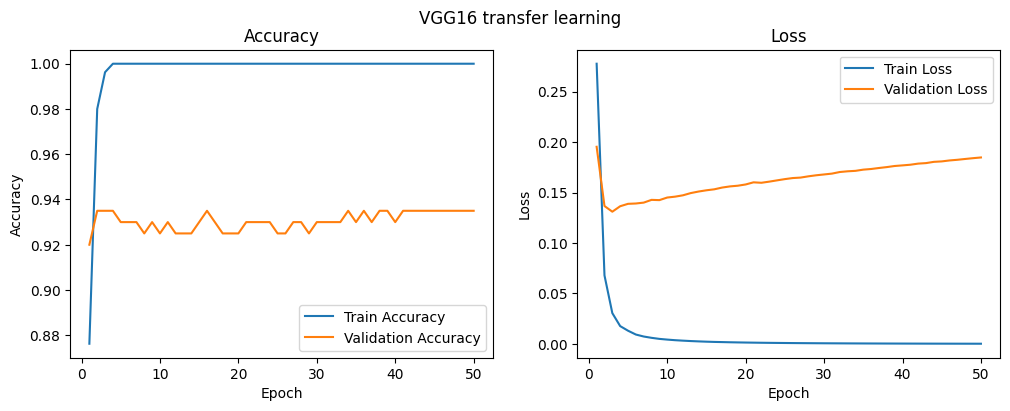

In [8]:
epochs = list(range(1, EPOCHS+1))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(epochs, train_acc, label='Train Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, train_losses, label='Train Loss')
ax2.plot(epochs, val_losses, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.suptitle('VGG16 transfer learning')
plt.show()

## Save classifier and optional fine-tuning

In [9]:
# save the classifier weights
torch.save(classifier.state_dict(), 'CTRL_OA_tlearn_basic_cnn_pytorch.pth')
print('Saved classifier weights to CTRL_OA_tlearn_basic_cnn_pytorch.pth')

Saved classifier weights to CTRL_OA_tlearn_basic_cnn_pytorch.pth


### Optinal fine-tuning

Is possible to unfreeze some of the layers of the pretrained model and fine-tune them along with the classifier. This can lead to better performance, especially if the new dataset is significantly different from the original dataset used for pretraining.

In this example just the last convolutional block of VGG16 is unfrozen for fine-tuning.

In [ ]:
# Fine-tuning: unfreeze last conv layers and run a short fine-tune
for param in vgg_features.parameters():
    param.requires_grad = False

for layer in list(vgg_features.children())[-6:]:
    for p in layer.parameters():
        p.requires_grad = True

# create a new model
model_finetune = TransferModel(vgg_features, classifier).to(DEVICE)

train_acc_fine_tuned, val_acc_fine_tuned, train_losses_fine_tuned, val_losses_fine_tuned = train_model(
    model_finetune,
    train_loader,
    val_loader
    )

Epoch 1/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1849 - val_acc: 0.9350
Epoch 2/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1854 - val_acc: 0.9350
Epoch 3/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1857 - val_acc: 0.9350
Epoch 4/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1859 - val_acc: 0.9350
Epoch 5/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1863 - val_acc: 0.9350
Epoch 6/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1864 - val_acc: 0.9350
Epoch 7/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1868 - val_acc: 0.9350
Epoch 8/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1870 - val_acc: 0.9350
Epoch 9/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1872 - val_acc: 0.9350
Epoch 10/10 - loss: 0.0002 - acc:  1.0000 - val_loss: 0.1875 - val_acc: 0.9350
Saved finetuned model.


In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(epochs, train_acc_fine_tuned, label='Train Accuracy')
ax1.plot(epochs, val_acc_fine_tuned, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, train_losses_fine_tuned, label='Train Loss')
ax2.plot(epochs, val_losses_fine_tuned, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

### Execise to try
Considering the previous fine tunning code, try unfreezing the  last two convolutional blocks of VGG16.

#### Try unfreezing more layers of the pretrained model and observe how it affects the performance.


<details>
  <summary>Click to show/hide the solution</summary>
  
```python
for layer in list(vgg_features.children())[-6:]:
    for p in layer.parameters():
        p.requires_grad = True
```
  
</details>


Change the number of layers to unfreeze and see how it affects the model's performance on the Cats vs Dogs dataset.

In [ ]:
# Fine-tuning: unfreeze ALL the conv layers and run
#################
#### YOU CODE HERE
#################
#################

# create a new model
model_full_trained = TransferModel(vgg_features, classifier).to(DEVICE)
train_acc_full_trained, val_acc_full_trained, train_losses_full_trained, val_losses_full_trained = train_model(
    model_full_trained,
    train_loader,
    val_loader
    )

In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(epochs, train_acc_full_trained, label='Train Accuracy')
ax1.plot(epochs, val_acc_full_trained, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, train_losses_full_trained, label='Train Loss')
ax2.plot(epochs, val_losses_full_trained, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()